In [1]:
!pip install datasets
from tqdm import tqdm
from datasets import list_datasets, load_dataset
import pickle
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
################################################################################
drive.mount('/content/drive', force_remount=True)
!cp /content/drive/MyDrive/NLP/UITws_v1.py /content
from UITws_v1 import UITws_v1
################################################################################
class MyDataset(Dataset):
  def __init__(self, x, y):
    self.data = x
    self.labels = y

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    return self.data[index], self.labels[index]
################################################################################
class Accuracy:
    """A class to keep track of the accuracy while training"""
    def __init__(self):
        self.correct = 0
        self.total = 0
        
    def reset(self):
        """Resets the internal state"""
        self.correct = 0
        self.total = 0
        
    def update(self, outputs, labels):
        """
        Updates the internal state to later compute the overall accuracy
        
        output: the output of the network for a batch
        labels: the target labels
        """
        _, predicted = torch.max(outputs.data, 1) # predicted now contains the predicted class index/label
        
        self.total += labels.size(0)
        self.correct += (predicted == labels).sum().item() # .item() gets the number, not the tensor
        #self.correct += ((outputs.data > 0.5) == labels).sum().item()

    def compute(self):
        return self.correct/self.total
################################################################################
def test_accu():
    net.eval()
    test_accuracy = Accuracy()
    test_accuracy.reset()        
    with torch.no_grad():
        for test_data in test_loader:
            # get the data points
            test_inputs, test_labels = test_data
            test_inputs, test_labels = test_inputs.to(device).long(), test_labels.to(device)
            # forward the data through the network
            test_outputs = net(test_inputs)
            
            test_accuracy.update(test_outputs, test_labels)
            
    print("\nTesting Accuracy: {:.2f}%".format(100 * test_accuracy.compute()))
################################################################################
dataset = load_dataset('uit-nlp/vietnamese_students_feedback')
word_seg = UITws_v1('/content/drive/MyDrive/NLP/base_sep_sfx.pkl')
################################################################################
from nltk import tokenize
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.6 MB/s 
     |████████████████████████████████| 163 kB 56.4 MB/s 
     |████████████████████████████████| 115 kB 50.7 MB/s 
     |████████████████████████████████| 212 kB 65.6 MB/s 
     |████████████████████████████████| 127 kB 49.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset vietnamese_students_feedback downloaded and prepared to /root/.cache/huggingface/datasets/uit-nlp___vietnamese_students_feedback/default/1.0.0/b01aa0fea00f1179ef9c093babb5e91f44bc60f19ded600754a08e018503e40f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_dataset = dataset['train']
test_dataset = dataset['test']
#train_dataset['sentence'][0]
#train_dataset['sentiment'][0]
segmented_texts = word_seg.segment(texts=train_dataset['sentence'], pre_tokenized=True, batch_size=256)
segmented_texts2 = word_seg.segment(texts=test_dataset['sentence'], pre_tokenized=True, batch_size=256)

In [ ]:
words = []
idx = -1
word2idx = {}
vectors = []

with open('/content/drive/MyDrive/NLP/word2vec_vi_words_100dims.txt', 'rb') as f:
    for l in tqdm(f):
        line = l.decode().split(' ')
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
del vectors[0]
del word2idx['1587507']
del words[0]
vectors = np.array(vectors)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
1587508it [05:08, 5141.13it/s]


In [ ]:
# pickle.dump(words, open('/content/drive/MyDrive/NLP/words_list.p', 'wb'))
# pickle.dump(word2idx, open('/content/drive/MyDrive/NLP/word2idx.p', 'wb'))
# pickle.dump(vectors, open('/content/drive/MyDrive/NLP/word_vectors.p', 'wb'))
#pickle.dump(vietnamese_w2v, open('/content/drive/MyDrive/NLP/vietnamese_w2v.p', 'wb'))

In [3]:
words = pickle.load(open('/content/drive/MyDrive/NLP/words_list.p','rb'))
word2idx = pickle.load(open('/content/drive/MyDrive/NLP/word2idx.p','rb'))
vectors = pickle.load(open('/content/drive/MyDrive/NLP/word_vectors.p','rb'))

In [4]:
vietnamese_w2v = {w: vectors[word2idx[w]] for w in words}

In [5]:
def word2ids_dataset(sen_list, maxlen, vector_size):
    x = torch.zeros((len(sen_list),1,maxlen))
    for i in tqdm(range(len(sen_list))):
      doc = tokenize.word_tokenize(sen_list[i])
      fil_doc_w2index = []
      for word in doc:
        try:
          fil_doc_w2index.append(word2idx[word])
        except Exception:
          pass
      if len(fil_doc_w2index)<=maxlen:
        x[i] = torch.cat((torch.LongTensor(fil_doc_w2index),torch.zeros(maxlen-len(fil_doc_w2index)))).unsqueeze(0)
      else:
        x[i] = torch.LongTensor(fil_doc_w2index[-maxlen-1:-1]).unsqueeze(0)
    return x

In [6]:
input_ids = word2ids_dataset(sen_list = segmented_texts, maxlen = 50, vector_size = 100)
input_ids2 = word2ids_dataset(sen_list = segmented_texts2, maxlen = 50, vector_size = 100)

100%|██████████| 3166/3166 [00:01<00:00, 3025.00it/s]


In [7]:
train_data = MyDataset(input_ids, train_dataset['sentiment'])
test_data = MyDataset(input_ids2, test_dataset['sentiment'])

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

In [9]:
def create_emb_layer(weights_matrix, non_trainable=False):
    weights_matrix = torch.Tensor(weights_matrix)
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.embedding, num_embeddings, vector_size = create_emb_layer(vectors, non_trainable=True)
        self.conv1 = nn.Conv2d(in_channels = 1,
                                out_channels = 100,
                                kernel_size = (2,vector_size))
        self.conv2 = nn.Conv2d(in_channels = 1,
                                out_channels = 100,
                                kernel_size = (3,vector_size))
        self.conv3 = nn.Conv2d(in_channels = 1,
                                out_channels = 100,
                                kernel_size = (4,vector_size))
        self.conv4 = nn.Conv2d(in_channels = 1,
                                out_channels = 100,
                                kernel_size = (5,vector_size))
        self.fc1 = nn.Linear(400, 3)
        self.dropout = nn.Dropout(0.30)
        self.dropout1 = nn.Dropout(0.30)
        self.dropout2 = nn.Dropout(0.30)
        self.dropout3 = nn.Dropout(0.30)
        self.dropout4 = nn.Dropout(0.30)
        self.dropout5 = nn.Dropout(0.30)
    def forward(self, x):
        x = self.dropout(self.embedding(x))
        x1 = F.relu(self.conv1(x))
        x1 = self.dropout1(F.max_pool2d(x1, (x1.size()[-2],1)))
        x2 = F.relu(self.conv2(x))
        x2 = self.dropout2(F.max_pool2d(x2, (x2.size()[-2],1)))
        x3 = F.relu(self.conv3(x))
        x3 = self.dropout3(F.max_pool2d(x3, (x3.size()[-2],1)))
        x4 = F.relu(self.conv4(x))
        x4 = self.dropout4(F.max_pool2d(x4, (x4.size()[-2],1)))
        x = torch.flatten(torch.cat((x1,x2,x3,x4),-3),start_dim=-3)
        x = self.fc1(self.dropout5(x))
        return x

net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

In [ ]:
#optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [56]:
#net = net.float()
net.train()
live_accuracy = Accuracy()

for epoch in range(20):  # loop over the dataset multiple times
    print("\nStarting epoch {}".format(epoch+1))

    live_accuracy.reset()
    total = 0
    running_loss = 0.0

    # to make a beautiful progress bar
    loader = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in loader:
        # get the data points
        inputs, labels = data
        inputs, labels = inputs.to(device).long(), labels.to(device)
        # zero the parameter gradients (else, they are accumulated)
        optimizer.zero_grad()

        # forward the data through the network
        outputs = net(inputs)
        # calculate the loss given the output of the network and the target labels
        loss = criterion(outputs, labels)
        # calculate the gradients of the network w.r.t. its parameters
        loss.backward()
        # Let the optimiser take an optimization step using the calculated gradients
        optimizer.step()
        
        running_loss += loss
        total += outputs.size(0)

        live_accuracy.update(outputs, labels)
        loader.set_description("loss: {:.5f}|acc: {:.2f}%".format(running_loss/total,100 * live_accuracy.compute()))
    test_accu()
    net.train()

print('Finished Training')


Starting epoch 1


loss: 0.00992|acc: 73.60%: 100%|██████████| 179/179 [00:17<00:00, 10.16it/s]



Testing Accuracy: 82.09%

Starting epoch 2


loss: 0.00704|acc: 82.65%: 100%|██████████| 179/179 [00:17<00:00, 10.29it/s]



Testing Accuracy: 84.93%

Starting epoch 3


loss: 0.00622|acc: 85.17%: 100%|██████████| 179/179 [00:18<00:00,  9.56it/s]



Testing Accuracy: 86.17%

Starting epoch 4


loss: 0.00587|acc: 86.01%: 100%|██████████| 179/179 [00:17<00:00, 10.25it/s]



Testing Accuracy: 86.99%

Starting epoch 5


loss: 0.00557|acc: 86.78%: 100%|██████████| 179/179 [00:17<00:00, 10.25it/s]



Testing Accuracy: 87.90%

Starting epoch 6


loss: 0.00532|acc: 87.54%: 100%|██████████| 179/179 [00:17<00:00, 10.23it/s]



Testing Accuracy: 88.28%

Starting epoch 7


loss: 0.00514|acc: 87.96%: 100%|██████████| 179/179 [00:17<00:00, 10.32it/s]



Testing Accuracy: 88.38%

Starting epoch 8


loss: 0.00503|acc: 88.34%: 100%|██████████| 179/179 [00:17<00:00, 10.28it/s]



Testing Accuracy: 89.04%

Starting epoch 9


loss: 0.00495|acc: 88.37%: 100%|██████████| 179/179 [00:17<00:00, 10.24it/s]



Testing Accuracy: 88.72%

Starting epoch 10


loss: 0.00469|acc: 89.49%: 100%|██████████| 179/179 [00:17<00:00, 10.29it/s]



Testing Accuracy: 88.91%

Starting epoch 11


loss: 0.00473|acc: 89.26%: 100%|██████████| 179/179 [00:17<00:00, 10.22it/s]



Testing Accuracy: 89.48%

Starting epoch 12


loss: 0.00449|acc: 89.59%: 100%|██████████| 179/179 [00:17<00:00, 10.12it/s]



Testing Accuracy: 88.95%

Starting epoch 13


loss: 0.00442|acc: 89.93%: 100%|██████████| 179/179 [00:17<00:00, 10.28it/s]



Testing Accuracy: 89.26%

Starting epoch 14


loss: 0.00440|acc: 89.82%: 100%|██████████| 179/179 [00:17<00:00, 10.26it/s]



Testing Accuracy: 89.70%

Starting epoch 15


loss: 0.00433|acc: 90.06%: 100%|██████████| 179/179 [00:17<00:00, 10.25it/s]



Testing Accuracy: 89.67%

Starting epoch 16


loss: 0.00423|acc: 90.29%: 100%|██████████| 179/179 [00:17<00:00, 10.28it/s]



Testing Accuracy: 89.39%

Starting epoch 17


loss: 0.00416|acc: 90.51%: 100%|██████████| 179/179 [00:17<00:00, 10.25it/s]



Testing Accuracy: 89.51%

Starting epoch 18


loss: 0.00425|acc: 90.15%: 100%|██████████| 179/179 [00:17<00:00, 10.26it/s]



Testing Accuracy: 89.83%

Starting epoch 19


loss: 0.00399|acc: 90.84%: 100%|██████████| 179/179 [00:17<00:00, 10.27it/s]



Testing Accuracy: 89.80%

Starting epoch 20


loss: 0.00394|acc: 91.24%: 100%|██████████| 179/179 [00:17<00:00, 10.21it/s]



Testing Accuracy: 89.86%
Finished Training


In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import copy
import pandas as pd
import plotly.express as px

plotting embeddings of first 1000 documents


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


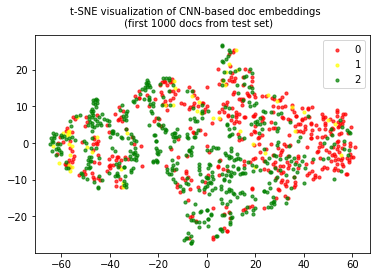

In [91]:
# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = net.embedding
num_sen = 1000
print('plotting embeddings of first',num_sen,'documents')

doc_emb = torch.flatten(get_doc_embedding(test_data.data[:num_sen].long()),start_dim=1).detach().numpy()

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=30)
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)
#doc_emb_tsne = my_tsne.fit_transform(doc_emb)

labels_plt = test_data.labels[:num_sen]
my_colors = ['red','yellow','green']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings_init.pdf',bbox_inches='tight')
fig.show()

plotting embeddings of first 1000 documents


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


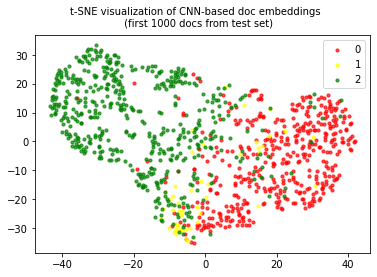

In [92]:
# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = copy.deepcopy(net)
get_doc_embedding.fc1 = torch.nn.Identity()
get_doc_embedding.eval()

num_sen = 1000
print('plotting embeddings of first',num_sen,'documents')

doc_emb = get_doc_embedding(test_data.data[:num_sen].long()).detach().numpy()

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=30)
doc_emb_pca = my_pca.fit_transform(doc_emb)
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca) 
#doc_emb_tsne = my_tsne.fit_transform(doc_emb)

labels_plt = test_data.labels[:num_sen]
my_colors = ['red','yellow','green']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ax.scatter(doc_emb_tsne[idxs,0], 
               doc_emb_tsne[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)
#fig.savefig(path_to_plot + 'doc_embeddings_init.pdf',bbox_inches='tight')
fig.show()

In [137]:
# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = copy.deepcopy(net)
get_doc_embedding.fc1 = torch.nn.Identity()
get_doc_embedding.eval()

num_sen = 1000
print('plotting embeddings of first',num_sen,'documents')

doc_emb = get_doc_embedding(test_data.data[:num_sen].long()).detach().numpy()

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=3,perplexity=30)
doc_emb_pca = my_pca.fit_transform(doc_emb)
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca) 
#doc_emb_tsne = my_tsne.fit_transform(doc_emb)

labels_plt = test_data.labels[:num_sen]
sentiment = ['neg','neu','pos']
d = {'x':doc_emb_tsne[:,0], 'y':doc_emb_tsne[:,1], 'z':doc_emb_tsne[:,2], 'label':[sentiment[label] for label in labels_plt]}
df = pd.DataFrame(data=d)
fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color='label',  color_discrete_map={"neg": "red", "neu":'yellow', "pos":"green"})
## text= '...' color=df.label
fig.update_traces(marker_size = 3)
fig.show()

plotting embeddings of first 1000 documents


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

